#### Install libraries

In [ ]:
!pip install foursquare
!pip install wget
!pip install folium
#!conda install -c conda-forge wordcloud==1.4.1 –yes
!pip install wordcloud

#### Import libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#package for parsing HTML and XML documents
from bs4 import BeautifulSoup

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

from IPython.display import HTML 
import base64

import foursquare #foursquare API client Copyright (c) 2020, Mike Lewis

# import wordcloud package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print('Libraries imported.')

Libraries imported.


#### Function for downloading dataframe as CSV

In [3]:
def create_download_link( dataframe, title = "Download CSV file", filename = "myout222.csv"):  
    csv = dataframe.to_csv() # create the csv 
    b64 = base64.b64encode(csv.encode()) # encode the file 
    payload = b64.decode() # set the payload
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html) # returning the link

##### credentials for loading CSV files

In [4]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-6a56ec78-9860-4733-a755-ef92f0e46673',
    'IBM_API_KEY_ID': 'KBhJ6ks4JAiniYg5z8xYAuTvThalOymY0TxsCwii3bUw',
    'ENDPOINT': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'ibmdatasciencecapstoneproject-donotdelete-pr-uvt1uyrc3n7fol',
    'FILE': 'chicago_artVenues500.csv'
}
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0


client_90d6f02f5b584ae7bd78588992e06754 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='KBhJ6ks4JAiniYg5z8xYAuTvThalOymY0TxsCwii3bUw',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')


### Extract Chicago community areas from Wikipedia

In [ ]:
url='https://en.wikipedia.org/wiki/Community_areas_in_Chicago'
website_url = requests.get(url).text
soup = BeautifulSoup(website_url,'lxml')
wikiTable = soup.find('table',{'class':'wikitable sortable plainrowheaders'})

community_areas=[]

table_rows = wikiTable.find_all('tr')
for tr in table_rows:
    th = tr.find_all('th')
    row=[tr.text for tr in th]
    if len(row)>0 :
        community_areas.append(row[0].replace('\n', ''))
        
#remove last element (city name)
del community_areas[-1]
#remove first element (table header)
del community_areas[0]

community_areas

### Get the coordinates of each neighborhoods using Nominatim

In [ ]:
# define the dataframe columns
column_names = ['community_areas','ll','lat','lon'] 
ChiCommunities = pd.DataFrame(columns=column_names)

# initialize Nominatim API  
geolocator = Nominatim(user_agent="geoapiExercises") 

for nb in community_areas:
    place = nb + ' Chicago'
    location = geolocator.geocode(place)
    if location:
        ll= location.raw['lat']+','+location.raw['lon']
        ChiCommunities = ChiCommunities.append({'community_areas': nb, 'll':ll, 'lat':location.raw['lat'],'lon':location.raw['lon']}, ignore_index=True)
    else:
        print("not found for %s" % place)
print(ChiCommunities.shape)
ChiCommunities.head()

#### download dataframe as CSV

In [ ]:
create_download_link(ChiCommunities)

Foursquare authentication

In [ ]:
# @hidden_cell
# Construct the client object
client = foursquare.Foursquare(client_id='VRWZHOS3DQ0FK42HEI2DXHHGMK41C0FJAPA4AVDUC34WN5CD', client_secret='VGNMNJB1WWRAI40VIR5ZA42R51INGRR40QJBBAZB23I4H33O', redirect_uri='http://fondu.com/oauth/authorize')

# Build the authorization url for your app
auth_uri = client.oauth.auth_url()
client

### Get food venues from foursquare

In [ ]:
# prepare dataframe for the results
    # foodCategroy - data for classification
    # venue_id - saved to remove duplicates
    # neighborhoods - for classification
    # burough - for comparing burough with most food venues
foodVenuesChicago = pd.DataFrame(columns=['foodCategroy','community_areas','venue_id','likes'])
i=0
radius='1000'
limit=200
foodcategoryId='4d4b7105d754a06374d81259'

#iterate over all neighborhoods and get venues data from foursquare
for nb,ll in zip(ChicagoCommunities['community_areas'],ChicagoCommunities['ll']):
    print('\n',nb, end='')
    fourSquareData=client.venues.search(params={'categoryId': foodcategoryId, 'll': ll,'radius':radius,'limit':limit})
    #count the number of neighborhoods without venues
    if len(fourSquareData['venues'])==0:
        print(" no venues in: ",nb, end='')
        i=i+1
    #extract data to foodVenes dataframe
    for j in range(len(fourSquareData['venues'])):
        id=pd.json_normalize(fourSquareData['venues'][j])['id'][0]
        fourSquareLikes=client.venues.likes(id)
        likes=pd.json_normalize(fourSquareLikes['likes'])['count'][0]
        works_data=pd.json_normalize(fourSquareData['venues'][j]['categories'])
        foodVenuesChicago.loc[foodVenuesChicago.shape[0]]=([works_data['shortName'][0],nb,id,likes])
print("\n community areas without venues: ",i)

In [ ]:
print("%s food venues found" % foodVenuesChicago.shape[0])
foodVenuesChicago.head()

In [ ]:
foodVenuesChicago.drop_duplicates(subset=['venue_id']).describe(include='all')

In [ ]:
foodVenuesChicago.describe(include='all')

#### save results to CSV

In [ ]:
foodVenuesChicago.drop_duplicates(subset=['venue_id']).to_csv('chicago_foodVenues500.csv')

#### Download results

In [ ]:
create_download_link(foodVenuesChicago.drop_duplicates(subset=['venue_id']))

In [44]:
foodVenuesChicago.replace('Beverly Hills','Beverly',inplace=True)
foodVenuesChicago.describe(include='all')

,foodCategroy,community_areas,venue_id,likes
count,4385,4385,4385,4385.000000
unique,160,77,4385,NaN
top,Mexican,Lincoln Square,52d6d072498e532af1719992,NaN
freq,370,139,1,NaN
mean,NaN,NaN,NaN,29.644698
std,NaN,NaN,NaN,104.822474
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,17.000000


### Get Arts & Entertainment venues from foursquare

In [ ]:
# prepare dataframe for the results
    # foodCategroy - data for classification
    # venue_id - saved to remove duplicates
    # neighborhoods - for classification
    # burough - for comparing burough with most food venues
artsVenuesChicago = pd.DataFrame(columns=['artCategroy','community_areas','venue_id','likes'])
i=0
radius='2500'
limit=200
ArtsCatId='4d4b7104d754a06370d81259'

#iterate over all neighborhoods and get venues data from foursquare
for nb,ll in zip(ChicagoCommunities['community_areas'],ChicagoCommunities['ll']):
    print('\n',nb, end='')
    fourSquareData=client.venues.search(params={'categoryId': ArtsCatId, 'll': ll,'radius':radius,'limit':limit})
    #count the number of neighborhoods without venues
    if len(fourSquareData['venues'])==0:
        print(" no venues in: ",nb, end='')
        i=i+1
    #extract data to foodVenes dataframe
    for j in range(len(fourSquareData['venues'])):
        print('.', end='')
        id=pd.json_normalize(fourSquareData['venues'][j])['id'][0]
        # Get number of venue likes
        fourSquareLikes=client.venues.likes(id)
        likes=pd.json_normalize(fourSquareLikes['likes'])['count'][0]
        works_data=pd.json_normalize(fourSquareData['venues'][j]['categories'])
        #add data to dataframe
        artsVenuesChicago.loc[artsVenuesChicago.shape[0]]=([works_data['shortName'][0],nb,id,likes])
    print(j, end='')
print("\n community areas without venues: ",i)

In [ ]:
print("%s art venues found" % artsVenuesChicago.shape[0])
artsVenuesChicago.head()

In [ ]:
artsVenuesChicago.describe(include='all')

In [ ]:
create_download_link(artsVenuesChicago)

In [ ]:
artsVenuesChicago.drop_duplicates(subset=['venue_id']).describe(include='all')

#### save results to csv

In [ ]:
artsVenuesChicago.drop_duplicates(subset=['venue_id']).to_csv('chicago_artVenues500.csv')

#### download results

In [ ]:
create_download_link(artsVenuesChicago.drop_duplicates(subset=['venue_id']))

In [10]:
artsVenuesChicago=df_data_16.drop('Unnamed: 0',axis=1)
print(artsVenuesChicago.shape)
artsVenuesChicago.head()

(2435, 4)


,foodCategroy,neighborhoods,venue_id,likes
0,Sculpture,Albany Park,4d596f0f24466ea85b7c779f,10.0
1,Art Gallery,Albany Park,4e31e1811fc7db5da4db9f6f,0.0
2,Rock Club,Albany Park,4bf280341cd9d13af6b2ed76,0.0
3,Tour Provider,Albany Park,5d98babef006540008634edb,0.0
4,Historic Site,Albany Park,4de00ac2ae605835c4490101,0.0


In [43]:
artsVenuesChicago.replace('Beverly Hills','Beverly',inplace=True)
artsVenuesChicago.describe(include='all')

,artCategroy,community_areas,venue_id,likes
count,2434,2434,2434,2434.000000
unique,123,77,2434,NaN
top,Art Gallery,West Town,4f32c17e19836c91c7f70c0e,NaN
freq,420,124,1,NaN
mean,NaN,NaN,NaN,25.271980
std,NaN,NaN,NaN,194.605248
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,2.000000


## Data analysis

### WordClouds of the food and arts venues

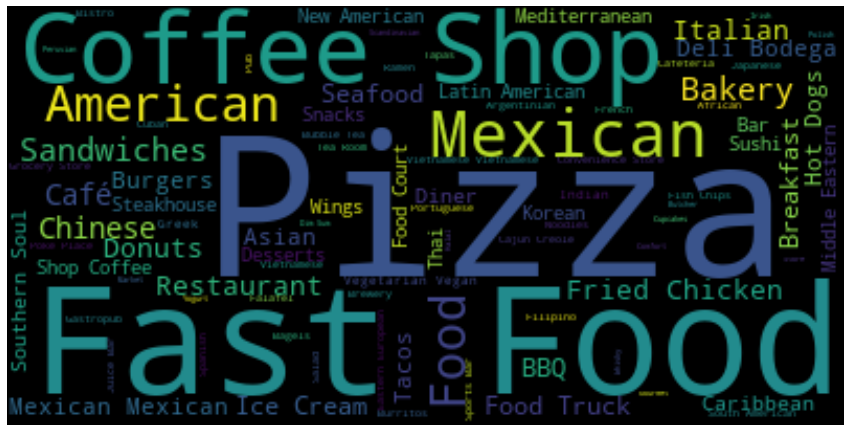

In [19]:
wordcloud = WordCloud().generate(' '.join(foodVenuesChicago['foodCategroy']))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

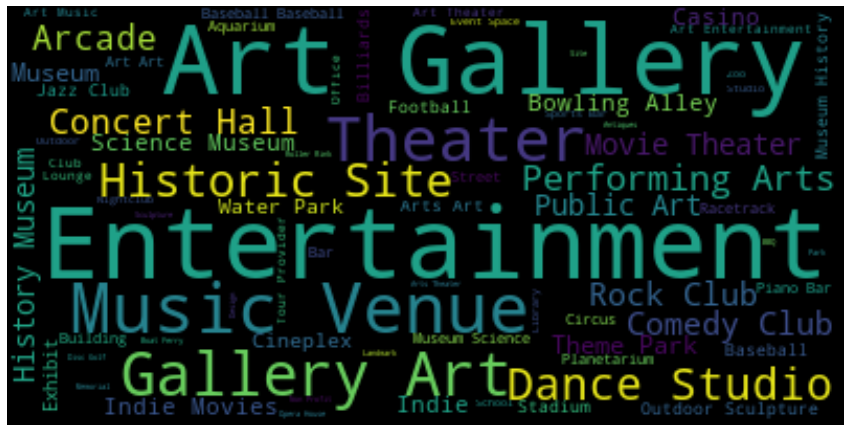

In [34]:
wordcloud = WordCloud().generate(' '.join(artsVenuesChicago['artCategroy']))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Review hitogram of the most common venue categories

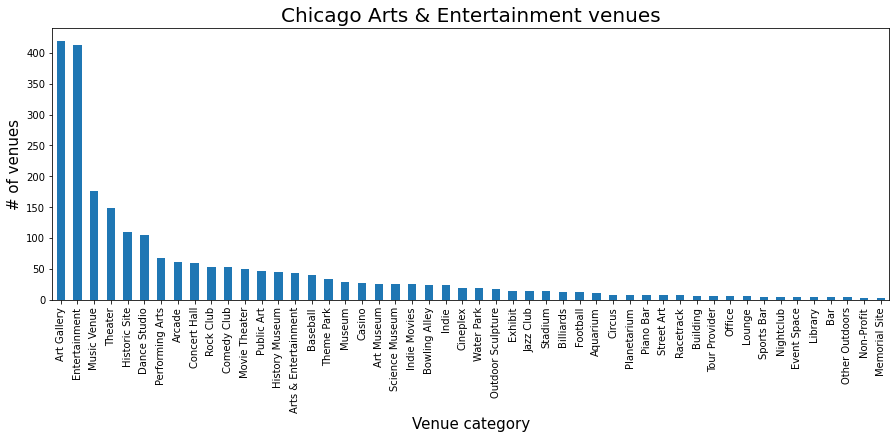

,artCategroy,count
6,Art Gallery,420
39,Entertainment,413
72,Music Venue,176
115,Theater,148
53,Historic Site,110


In [35]:
tempDf=artsVenuesChicago.groupby('artCategroy',axis=0).count()
tempDf.drop(['venue_id','likes'], axis=1, inplace=True)
tempDf.columns=['count']
#df_tests.sort_values(by='count', ascending=False, axis=0).head(15)
tempDf.reset_index(inplace=True)
#df_tests.['foodCategroy'].plot(kind='hist',figsize=(5, 5),x='count')
tempDf.sort_values(by='count', ascending=False, axis=0).head(50).plot.bar(x='artCategroy', 
                                                                            y='count',
                                                                            figsize=(15, 5),
                                                                            legend=False
                                                                           )
plt.title('Chicago Arts & Entertainment venues', fontsize=20)
plt.xlabel('Venue category', fontsize=15)
plt.ylabel('# of venues', fontsize=15)
plt.show()
tempDf.sort_values(by='count', ascending=False, axis=0).head()

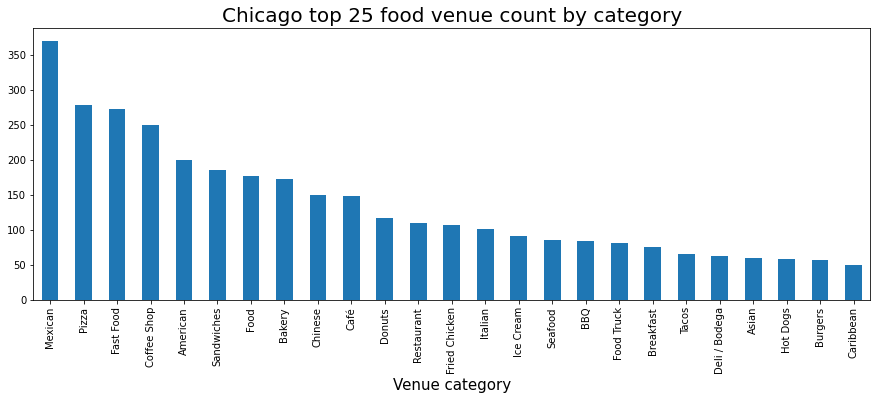

,foodCategroy,count
95,Mexican,370
112,Pizza,278
54,Fast Food,273
31,Coffee Shop,250
1,American,200
123,Sandwiches,185
58,Food,177
8,Bakery,173
28,Chinese,149
23,Café,148


In [149]:
tempDf=foodVenuesChicago.groupby('foodCategroy',axis=0).count()
tempDf.drop(['venue_id','likes'], axis=1, inplace=True)
tempDf.columns=['count']
#df_tests.sort_values(by='count', ascending=False, axis=0).head(15)
tempDf.reset_index(inplace=True)
#df_tests.['foodCategroy'].plot(kind='hist',figsize=(5, 5),x='count')
tempDf.sort_values(by='count', ascending=False, axis=0).head(25).plot.bar(x='foodCategroy', 
                                                                            y='count',
                                                                            figsize=(15, 5),
                                                                            legend=False
                                                                           )
plt.title('Chicago top 25 food venue count by category', fontsize=20)
plt.xlabel('Venue category', fontsize=15)
#plt.ylabel('Number of venues', fontsize=15)
plt.show()
tempDf.sort_values(by='count', ascending=False, axis=0).head(25)

#### Review the food venues count per community area

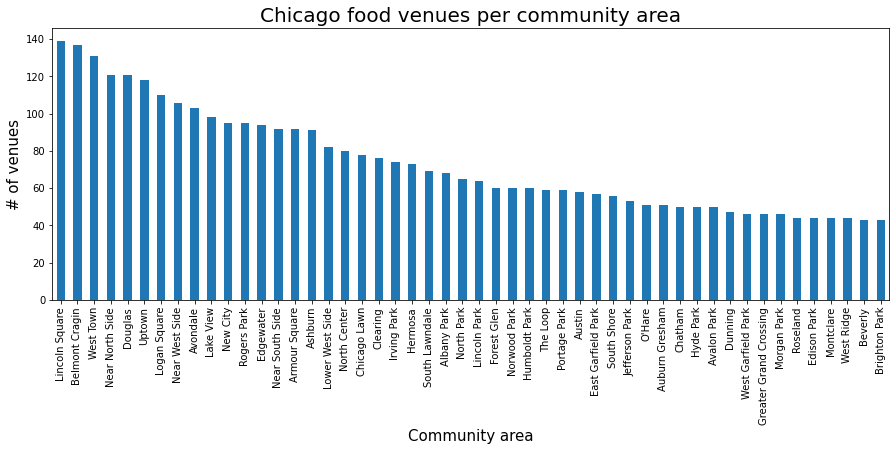

,community_areas,count
39,Lincoln Square,139
8,Belmont Cragin,137
75,West Town,131
46,Near North Side,121
17,Douglas,121


In [45]:
df_sorted_neighborhoods=foodVenuesChicago.groupby('community_areas',axis=0).count()
df_sorted_neighborhoods.drop(['venue_id','likes'], axis=1, inplace=True)
df_sorted_neighborhoods.head(15)
df_sorted_neighborhoods.columns=['count']
df_sorted_neighborhoods.reset_index(inplace=True)
df_sorted_neighborhoods.sort_values(by='count', ascending=False, axis=0).head(50).plot.bar(x='community_areas', 
                                                                            y='count',
                                                                            figsize=(15, 5),
                                                                            legend=False
                                                                           )
plt.title('Chicago food venues per community area', fontsize=20)
plt.xlabel('Community area', fontsize=15)
plt.ylabel('# of venues', fontsize=15)
plt.show()
df_sorted_neighborhoods.sort_values(by='count', ascending=False, axis=0).head()

#### Review the Arts & Entertainment venues count per community area

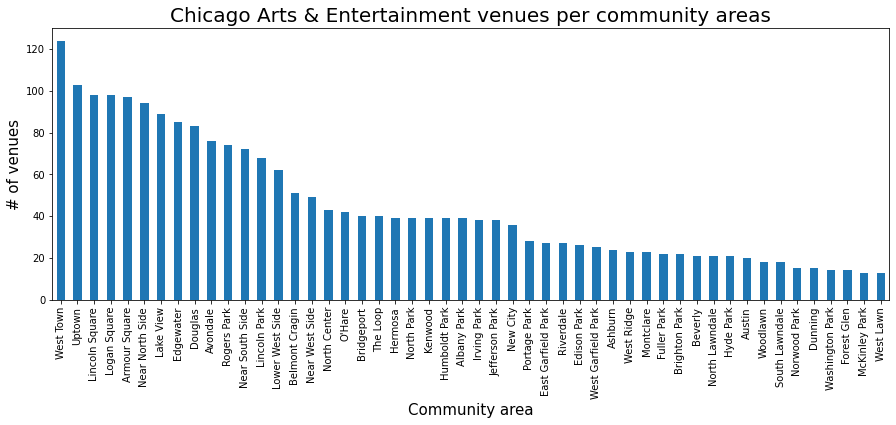

,community_areas,count
75,West Town,124
66,Uptown,103
39,Lincoln Square,98
40,Logan Square,98
2,Armour Square,97


In [46]:
df_sorted_neighborhoods=artsVenuesChicago.groupby('community_areas',axis=0).count()
df_sorted_neighborhoods.drop(['venue_id','likes'], axis=1, inplace=True)
df_sorted_neighborhoods.columns=['count']
df_sorted_neighborhoods.reset_index(inplace=True)
df_sorted_neighborhoods.sort_values(by='count', ascending=False, axis=0).head(50).plot.bar(x='community_areas', 
                                                                            y='count',
                                                                            figsize=(15, 5),
                                                                            legend=False
                                                                           )
plt.title('Chicago Arts & Entertainment venues per community areas', fontsize=20)
plt.xlabel('Community area', fontsize=15)
plt.ylabel('# of venues', fontsize=15)
plt.show()
df_sorted_neighborhoods.sort_values(by='count', ascending=False, axis=0).head()

### review relation between number of food venues and number of Arts & Entertainment venues per neighborhood

Create a data frame of arts & entertainment venues count per community area

In [47]:
df_art_count=artsVenuesChicago.groupby('community_areas',axis=0).count()
df_art_count.drop(['venue_id','likes'], axis=1, inplace=True)
df_art_count.columns=['count']
df_art_count.reset_index(inplace=True)
df_art_count.rename(columns={"count": "art_count"}, inplace=True)
df_art_count.describe(include='all')

,community_areas,art_count
count,77,77.000000
unique,77,NaN
top,West Pullman,NaN
freq,1,NaN
mean,NaN,31.610390
std,NaN,29.978569
min,NaN,1.000000
25%,NaN,10.000000
50%,NaN,21.000000
75%,NaN,40.000000


Create a data frame of food venues count per community area

In [48]:
df_food_count=foodVenuesChicago.groupby('community_areas',axis=0).count()
df_food_count.drop(['venue_id','likes'], axis=1, inplace=True)
df_food_count.columns=['count']
df_food_count.reset_index(inplace=True)
df_food_count.rename(columns={"count": "food_count"}, inplace=True)
df_food_count.describe(include='all')

,community_areas,food_count
count,77,77.000000
unique,77,NaN
top,West Pullman,NaN
freq,1,NaN
mean,NaN,56.948052
std,NaN,32.862111
min,NaN,4.000000
25%,NaN,34.000000
50%,NaN,50.000000
75%,NaN,76.000000


Merge the dataframes to a single dataframe of count of venues per community area

In [49]:
df_merged_venues = pd.merge(df_food_count, df_art_count, on="community_areas")
print(df_merged_venues.shape)
df_merged_venues.head()

(77, 3)


,community_areas,food_count,art_count
0,Albany Park,68,39
1,Archer Heights,39,11
2,Armour Square,92,97
3,Ashburn,91,24
4,Auburn Gresham,51,8


In [50]:
#download the dataframe
create_download_link(df_merged_venues)

Add a 'ratio' column to the dataframe - ratio between the food venues count and arts and entertainment count per community area

In [51]:
ratio=[]
for fd, art in zip(df_merged_venues['food_count'],df_merged_venues['art_count']):
    if art:
        ratio.append(fd/art)
df_merged_venues['ratio']=ratio
df_merged_venues.head()

,community_areas,food_count,art_count,ratio
0,Albany Park,68,39,1.743590
1,Archer Heights,39,11,3.545455
2,Armour Square,92,97,0.948454
3,Ashburn,91,24,3.791667
4,Auburn Gresham,51,8,6.375000


Review the ratio values

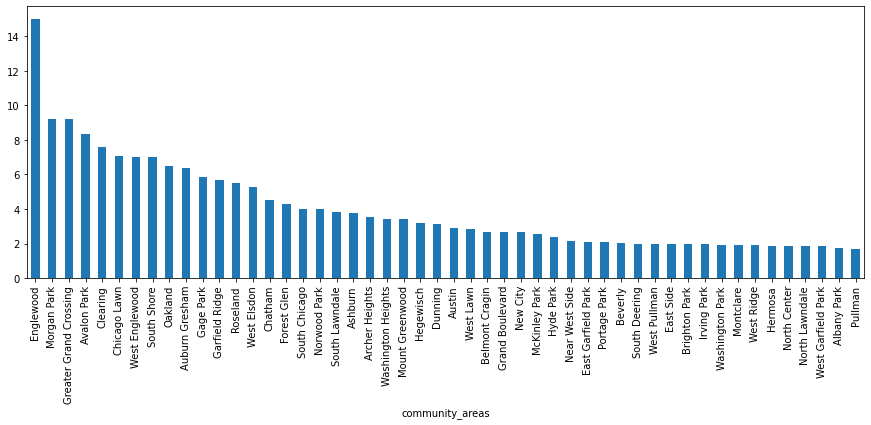

In [64]:
df_merged_venues.sort_values(by='ratio', ascending=False, axis=0).head(50).plot.bar(x='community_areas', 
                                                                            y='ratio',
                                                                            figsize=(15, 5),
                                                                            legend=False
                                                                           )

#### descriptive statistics

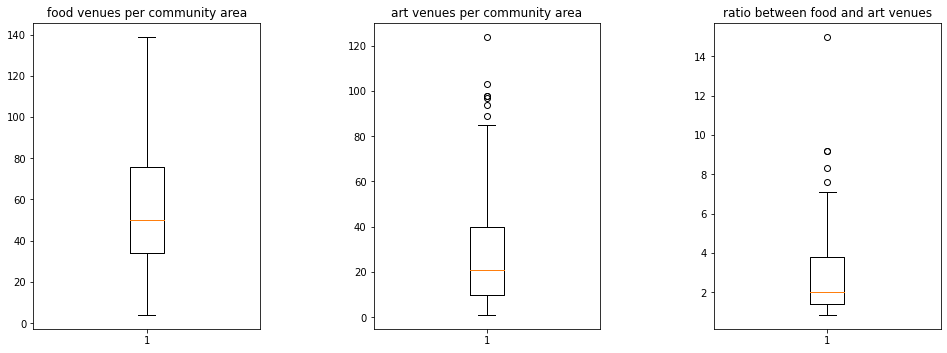

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# basic plot
axs[0].boxplot(df_merged_venues["food_count"])
axs[0].set_title('food venues per community area')

# basic plot
axs[1].boxplot(df_merged_venues["art_count"])
axs[1].set_title('art venues per community area')

# basic plot
axs[2].boxplot(df_merged_venues["ratio"])
axs[2].set_title('ratio between food and art venues')


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.5)

plt.show()

Filter the community areas with ratio < 2 and number of arts & entertainment count > 10

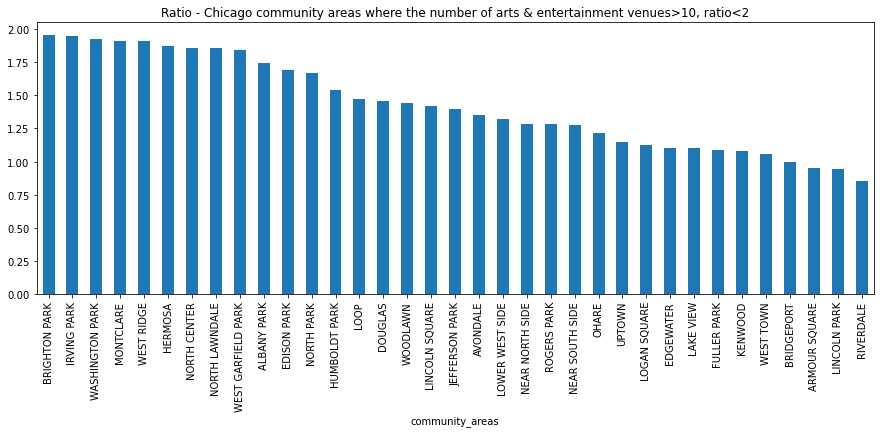

In [139]:
df6=df_merged_venues.loc[df_merged_venues['ratio'] < 2].loc[df_merged_venues['art_count'] > 10]
df6.sort_values(by='ratio', ascending=False, axis=0).plot.bar(x='community_areas', 
                                                              y='ratio',
                                                              figsize=(15, 5),
                                                              legend=False,
                                                              title="Ratio - Chicago community areas where the number of arts & entertainment venues>10, ratio<2"
                                                              )

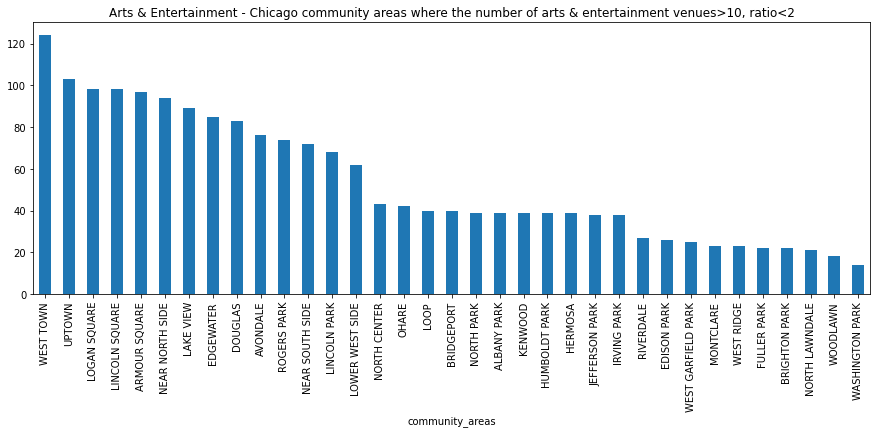

In [140]:
df6.sort_values(by='art_count', ascending=False, axis=0).plot.bar(x='community_areas', 
                                                              y='art_count',
                                                              figsize=(15, 5),
                                                              legend=False,
                                                              title="Arts & Entertainment - Chicago community areas where the number of arts & entertainment venues>10, ratio<2"
                                                              )

Top 10 community areas with ratio < 2 and number of arts & entertainment count > 10 sorted by arts & entertainment venues count

In [145]:
df6.sort_values(by='art_count', ascending=False, axis=0).head(10)

,food_count,art_count,ratio,community_areas
75,131,124,1.056452,WEST TOWN
66,118,103,1.145631,UPTOWN
40,110,98,1.122449,LOGAN SQUARE
39,139,98,1.418367,LINCOLN SQUARE
2,92,97,0.948454,ARMOUR SQUARE
46,121,94,1.287234,NEAR NORTH SIDE
37,98,89,1.101124,LAKE VIEW
21,94,85,1.105882,EDGEWATER
17,121,83,1.457831,DOUGLAS
7,103,76,1.355263,AVONDALE


#### Folium map of the community areas with ratio < 2 and number of arts & entertainment count > 10

In [153]:
#url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
geoJsonUrl = "https://raw.githubusercontent.com/RandomFractals/ChicagoCrimes/master/data/chicago-community-areas.geojson"
state_geo = r"https://raw.githubusercontent.com/RandomFractals/ChicagoCrimes/master/data/chicago-community-areas.geojson"

m = folium.Map(location=[41.8755616, -87.6244212], 
               width=600, 
               height=800,
               zoom_start=11
              )

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=df6,
    columns=['community_areas', 'art_count'],
    key_on='feature.properties.community',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    control_scale = True,
    legend_name="Number of art venues"
).add_to(m)

folium.LayerControl().add_to(m)

m
